## BSTS Model vs ARIMA Model For Sales Forecasting, Based on Sales Data.

#### Online Retail Dataset from the UCI Machine Learning Repository is available at the following [link](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx);




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()
os.chdir('your-path')

In [ ]:
# Set up the environment
!pip install numpy pandas statsmodels matplotlib tensorflow tensorflow-probability

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
import os
import shutil
from glob import glob

In [ ]:
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
# Load the data (Online Retail Dataset from the UCI Machine Learning Repository)
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
data = pd.read_excel(url)

In [ ]:
# Few rows of the data:
data.head()

,InvoiceDate,index,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,2010-12-01 08:26:00,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
1,2010-12-01 08:26:00,1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2,2010-12-01 08:26:00,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
3,2010-12-01 08:26:00,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
4,2010-12-01 08:26:00,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom


In [ ]:
# Reset index to handle 'InvoiceDate'
data.reset_index(inplace=True)

In [ ]:
# Preprocess data.
# Convert 'InvoiceDate' to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Ensure 'Quantity' and 'UnitPrice' are numeric and handle non-numeric values by converting errors to NaN
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data['UnitPrice'] = pd.to_numeric(data['UnitPrice'], errors='coerce')

# Drop rows with NaN values in 'Quantity' or 'UnitPrice'
data.dropna(subset=['Quantity', 'UnitPrice'], inplace=True)


In [ ]:
# Set 'InvoiceDate' as index
data.set_index('InvoiceDate', inplace=True)

In [ ]:
# Calculate sales
data['Sales'] = data['Quantity'] * data['UnitPrice']

In [ ]:
# Aggregate sales by day
daily_sales = data['Sales'].resample('D').sum()

In [ ]:
# Filter out days with zero sales
daily_sales = daily_sales[daily_sales > 0]

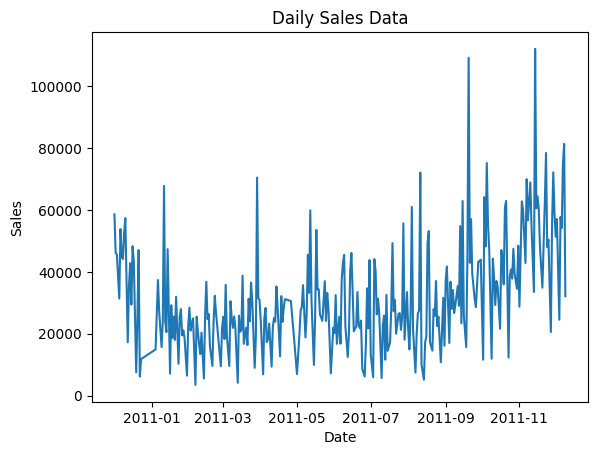

In [ ]:
# Plot the sales data
plt.plot(daily_sales.index, daily_sales)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales Data')
plt.show()

In [ ]:
# Extract sales as a time series
sales = daily_sales.values
time = np.arange(len(sales))

### BSTS Model

In [ ]:
# Define the Bayesian Structural Time Series (BSTS) model
class BayesianStructuralTimeSeries(tf.keras.Model):
    def __init__(self):
        super(BayesianStructuralTimeSeries, self).__init__()
        self.trend_loc = tf.Variable(0.0)
        self.trend_scale = tfp.util.TransformedVariable(1.0, tfp.bijectors.Softplus())
        self.seasonality_amplitude = tfp.util.TransformedVariable(1.0, tfp.bijectors.Softplus())
        self.seasonality_frequency = tfp.util.TransformedVariable(0.1, tfp.bijectors.Softplus())
        self.seasonality_phase = tf.Variable(0.0)

    def call(self, t):
        t = tf.cast(t, tf.float32)
        trend = self.trend_loc + self.trend_scale * t
        seasonality = self.seasonality_amplitude * tf.sin(self.seasonality_frequency * t + self.seasonality_phase)
        return trend + seasonality

In [ ]:
# Instantiate the BSTS model
bsts_model = BayesianStructuralTimeSeries()

In [ ]:
# Define the negative log likelihood loss function for BSTS
def nll(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    dist = tfd.Normal(loc=y_pred, scale=tf.constant(1.0))
    return -tf.reduce_mean(dist.log_prob(y_true))

In [ ]:
# Compile and train the BSTS model
bsts_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=nll)
bsts_model.fit(time, sales, epochs=1000, verbose=False)

In [ ]:
# Set the forecast horizon
forecast_horizon = 30  # forecast for next 30 days


In [ ]:
# Make BSTS predictions for next 30 days
time_forecast_bsts = np.arange(len(time), len(time) + forecast_horizon)
sales_forecast_bsts = bsts_model(time_forecast_bsts)


In [ ]:
# Combine time for plotting
combined_time_bsts = np.concatenate([time, time_forecast_bsts])
combined_sales_bsts = np.concatenate([sales, sales_forecast_bsts])

### ARIMA Model

In [ ]:
# Convert to pandas Series
sales_series = pd.Series(sales)

In [ ]:
# Fit the ARIMA model
arima_model = SARIMAX(sales_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
arima_model_fit = arima_model.fit(disp=False)

In [ ]:
# Make ARIMA predictions
arima_forecast = arima_model_fit.get_forecast(steps=forecast_horizon)
arima_forecast_index = np.arange(len(time), len(time) + forecast_horizon)
arima_forecast_values = arima_forecast.predicted_mean
arima_forecast_conf_int = arima_forecast.conf_int()


In [ ]:
# Combine time for plotting
combined_time_arima = np.concatenate([time, arima_forecast_index])
combined_sales_arima = np.concatenate([sales, arima_forecast_values])

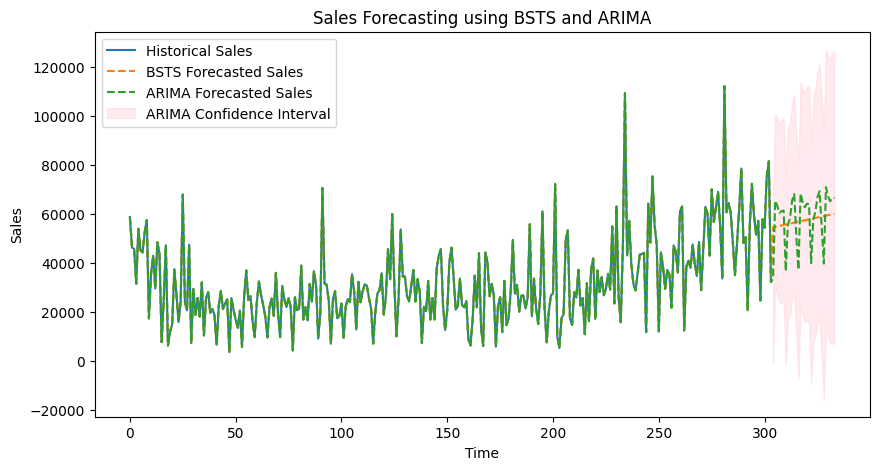

In [ ]:
# Plot both forecasts
plt.figure(figsize=(10, 5))
plt.plot(time, sales, label='Historical Sales')
plt.plot(combined_time_bsts, combined_sales_bsts, label='BSTS Forecasted Sales', linestyle='--')
plt.plot(combined_time_arima, combined_sales_arima, label='ARIMA Forecasted Sales', linestyle='--')
plt.fill_between(arima_forecast_index, arima_forecast_conf_int.iloc[:, 0], arima_forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='ARIMA Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales Forecasting using BSTS and ARIMA')
plt.legend()
plt.show()